In [1]:
"""
Wildfire perimeters:
- Gather wildfire perimeters from FIRED (2018-2023) for the western US
- Calculate the LANDFIRE EVT (ca. 2016) categorical percentages
- Filter for wildfires where aspen cover >= 5%

Fire Radiative Power (FRP):
Read in the archived FRP data from the SUOMI VIIRS C2 (375m Obs.) as shapefile for the western U.S. (2018-2023)
Downloaded for western US from the LAADS archive: https://firms.modaps.eosdis.nasa.gov/download/
- Extract VIIRS observations within aspen wildfires
- Filter out low confidence observations
- Create the VIIRS "plot" using a square 375m buffer

Save these files out for further analysis and to ingest into Google Earth Engine

maxwell.cook@colorado.edu
"""

import os, time
import numpy as np

import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import rasterio as rio
import matplotlib
import matplotlib.pyplot as plt

from rasterstats import zonal_stats

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'

print("Complete")

Complete


## Wrangle the wildfire data

First, we need to identify wildfire events across the western U.S. which had at least 5% pre-fire aspen cover. We start with a database of FIRED events extracted to western US states. We then calculate the zonal histogram from the LANDFIRE EVT (ca. 2016 remap). From there, we can identify wildfires with >5% aspen cover.

In [2]:
# Load the FIRED perimeters (2018-2022)
fired_path = os.path.join(maindir,'aspen-fire/Aim2/data/spatial/mod/FIRED/fired_events_west.gpkg')
fired = gpd.read_file(fired_path).to_crs(proj)
fired['ig_year'] = fired['ig_year'].astype(int)
fired = fired[(fired['ig_year'] >= 2018) & (fired['ig_year'] <= 2023)]

# Tidy some of the columns
fired = fired.rename(columns={'id': 'fired_id'})
fired['fired_id'] = fired['fired_id'].astype(str)
fired['ig_year'] = fired['ig_year'].astype(int)

print(f"{fired['ig_year'].min()}, {fired['ig_year'].max()}")
print(len(fired['fired_id'].unique()))

2018, 2023
8867


In [5]:
# Load the LANDFIRE EVT (ca. 2016)
evt_path = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/Tif/LC16_EVT_200.tif')
evt = rxr.open_rasterio(evt_path, masked=True).squeeze()
shp, gt, wkt, nd = evt.shape, evt.spatial_ref.GeoTransform, evt.rio.crs, evt.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {evt[0].dtype}")

Shape: (97283, 154207); 
GeoTransform: -2362425.0 30.0 0.0 3177435.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


In [6]:
# Calculate the percent cover of forest types from the LANDFIRE EVT
begin = time.time()
zs = zonal_stats(vectors=fired[['fired_id','geometry']], raster=evt_path, categorical=True, geojson_out=True)
print(f"Total elapsed time: {round((time.time() - begin))} seconds.")

Total elapsed time: 95 seconds.


In [7]:
stats = gpd.GeoDataFrame(zs).fillna(0) #One column per raster category, and pixel count as value
print(stats.head())
print(len(stats['id'].unique()))

del zs, evt, shp, gt, wkt, nd

   id     type                                         properties  \
0   6  Feature  {'fired_id': '10', 7035: 1, 7037: 99, 7039: 81...   
1   9  Feature  {'fired_id': '13', 7035: 8, 7036: 5, 7037: 98,...   
2  11  Feature  {'fired_id': '15', 7037: 80, 7039: 141, 7043: ...   
3  14  Feature  {'fired_id': '18', 7036: 411, 7037: 7, 7039: 3...   
4  15  Feature  {'fired_id': '19', 7008: 4, 7037: 60, 7039: 84...   

                                            geometry  \
0  {'type': 'MultiPolygon', 'coordinates': [(((-2...   
1  {'type': 'MultiPolygon', 'coordinates': [(((-2...   
2  {'type': 'MultiPolygon', 'coordinates': [(((-2...   
3  {'type': 'MultiPolygon', 'coordinates': [(((-2...   
4  {'type': 'MultiPolygon', 'coordinates': [(((-2...   

                                                bbox  
0  (-2204367.74113832, 2575991.3031250844, -22033...  
1  (-2218189.4634304265, 2575287.9877730696, -221...  
2  (-2221181.6184710697, 2572788.3472813834, -222...  
3  (-2259652.3826857344, 257

In [8]:
# Explore the properties json

# First get the fired_id
stats['fired_id'] = stats['properties'].apply(lambda x: x.get('fired_id'))

# Retrieve the other properties (EVT codes)
stats['properties'] = stats['properties'].apply(lambda x: {key: val for key, val in x.items() if key != 'fired_id'})
stats['properties_list'] = stats['properties'].apply(lambda x: list(x.items()))

# Explode the json
props = stats.explode('properties_list').reset_index(drop=True)

# retrieve the list items as new columns
props[['EVT', 'pixel_count']] = pd.DataFrame(props['properties_list'].tolist(), index=props.index)
props = props[['fired_id','EVT','pixel_count']].reset_index(drop=True)

# Calculate the percent of each class
total_pixels = props.groupby(props['fired_id'])['pixel_count'].transform('sum')
props['total_pixels'] = total_pixels
props['pct_cover'] = (props['pixel_count'] / props['total_pixels']) * 100

print(props)

print(len(props['fired_id'].unique()))
print(props.columns)

del stats, total_pixels

       fired_id   EVT  pixel_count  total_pixels  pct_cover
0            10  7035            1           242   0.413223
1            10  7037           99           242  40.909091
2            10  7039           81           242  33.471074
3            10  7043           54           242  22.314050
4            10  7063            2           242   0.826446
...         ...   ...          ...           ...        ...
124131   190732  9513           13         19182   0.067772
124132   190732  9514          578         19182   3.013242
124133   190732  9515           33         19182   0.172036
124134   190732  9516          497         19182   2.590971
124135   190732  9816          534         19182   2.783860

[124136 rows x 5 columns]
8867
Index(['fired_id', 'EVT', 'pixel_count', 'total_pixels', 'pct_cover'], dtype='object')


In [9]:
# Read in the lookup table for the EVT codes
lookup = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/CSV_Data/LF16_EVT_200.csv')
lookup = pd.read_csv(lookup)
print(lookup.columns)

Index(['VALUE', 'EVT_NAME', 'LFRDB', 'EVT_FUEL', 'EVT_FUEL_N', 'EVT_LF',
       'EVT_PHYS', 'EVT_GP', 'EVT_GP_N', 'SAF_SRM', 'EVT_ORDER', 'EVT_CLASS',
       'EVT_SBCLS', 'R', 'G', 'B', 'RED', 'GREEN', 'BLUE'],
      dtype='object')


In [10]:
### Subset the codes we want to join, join back to the dataframe
lookup = lookup[['VALUE','EVT_NAME','EVT_PHYS','EVT_GP_N','EVT_CLASS']]
props_df = props.merge(lookup, left_on='EVT', right_on='VALUE', how='left')
print(props_df.head())
print(len(props_df['fired_id'].unique()))

del lookup

  fired_id   EVT  pixel_count  total_pixels  pct_cover  VALUE  \
0       10  7035            1           242   0.413223   7035   
1       10  7037           99           242  40.909091   7037   
2       10  7039           81           242  33.471074   7039   
3       10  7043           54           242  22.314050   7043   
4       10  7063            2           242   0.826446   7063   

                                            EVT_NAME  EVT_PHYS  \
0  North Pacific Dry Douglas-fir-(Madrone) Forest...   Conifer   
1  North Pacific Maritime Dry-Mesic Douglas-fir-W...   Conifer   
2  North Pacific Maritime Mesic-Wet Douglas-fir-W...   Conifer   
3    Mediterranean California Mixed Evergreen Forest   Conifer   
4           North Pacific Broadleaf Landslide Forest  Hardwood   

                                          EVT_GP_N           EVT_CLASS  
0                  Douglas-fir Forest and Woodland  Closed tree canopy  
1  Douglas-fir-Western Hemlock Forest and Woodland  Closed tree ca

In [11]:
# Identify classes with 'aspen' in the EVT_NAME
aspen_evt = props_df[props_df['EVT_NAME'].str.contains('aspen', case=False, na=False)]['EVT_NAME'].unique()
print(aspen_evt)

['Rocky Mountain Aspen Forest and Woodland'
 'Inter-Mountain Basins Aspen-Mixed Conifer Forest and Woodland'
 'Northwestern Great Plains Aspen Forest and Parkland']


In [13]:
# Now filter to retain wildfire events with at least 5% aspen forest cover
props_filtered = props_df[props_df['EVT_NAME'].isin(aspen_evt)]
aspen_sum = props_filtered.groupby('fired_id')['pct_cover'].sum().reset_index() # get the sum of aspen classes
aspen_sum['pct_aspen'] = aspen_sum['pct_cover']  # rename the column to retain aspen percent
aspen_fires = aspen_sum[aspen_sum['pct_aspen'] >= 5] # retain fires with >= 5% 
aspen_fires = aspen_fires[['fired_id','pct_aspen']]
print(aspen_fires)

     fired_id  pct_aspen
7      189371  11.475541
14     189505  13.211368
15     189508  58.033241
16     189514  61.787865
17     189516  10.328717
...       ...        ...
1291    81343  24.608150
1292    81348   7.935393
1293    81355  10.354413
1297    82007   7.802875
1298    82031   6.261520

[420 rows x 2 columns]


In [14]:
# Join back to the FIRED data

# Check for matching fired_id set
common_ids = set(fired['fired_id']).intersection(set(aspen_fires['fired_id'])) # Find intersection
print(f"Number of common IDs: {len(common_ids)}")

# Join the attribute data to FIRED polygons
fired['fired_id'] = fired['fired_id'].astype(str)
aspen_fires['fired_id'] = aspen_fires['fired_id'].astype(str)

# Join aspen percent to the FIRED data
fired_aspen = pd.merge(fired, aspen_fires, on='fired_id', how='inner')
print(len(fired_aspen['fired_id'].unique()))

print(fired_aspen.columns)

Number of common IDs: 420
420
Index(['fired_id', 'ig_date', 'ig_day', 'ig_month', 'ig_year', 'last_date',
       'event_dur', 'tot_pix', 'tot_ar_km2', 'fsr_px_dy', 'fsr_km2_dy',
       'mx_grw_px', 'mn_grw_px', 'mu_grw_px', 'mx_grw_km2', 'mn_grw_km2',
       'mu_grw_km2', 'mx_grw_dte', 'x', 'y', 'ig_utm_x', 'ig_utm_y', 'lc_code',
       'lc_mode', 'lc_name', 'lc_desc', 'lc_type', 'eco_mode', 'eco_name',
       'eco_type', 'tot_perim', 'geometry', 'pct_aspen'],
      dtype='object')


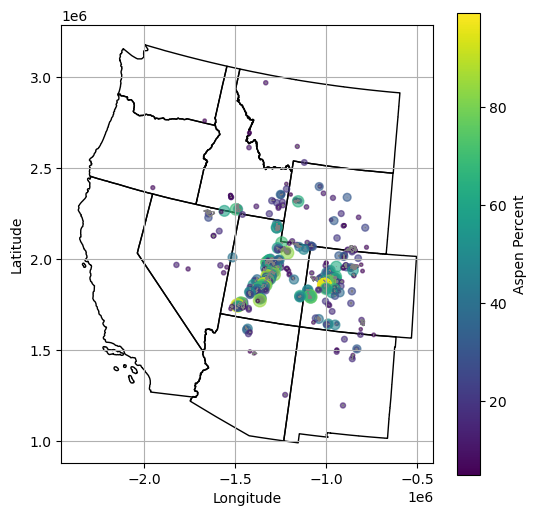

In [17]:
# Spatial map of aspen wildfires (centroid)

# Load the state boundaries
states = gpd.read_file(os.path.join(maindir,'data/boundaries/political/TIGER/tl19_us_states_west_nad83.gpkg'))

# Generate centroids
centroid = fired_aspen.copy()
centroid['geometry'] = centroid.geometry.centroid

# Make a spatial map of the centroids now
fig, ax = plt.subplots(figsize=(6, 6))

states.plot(ax=ax, edgecolor='black', linewidth=1, color='none')

# Plot centroids
centroid['size'] = centroid['pct_aspen'] * 10  # Adjust the scaling factor as necessary
centroid.plot(
    ax=ax, markersize=centroid['pct_aspen'], 
    column='pct_aspen', cmap='viridis', 
    legend=True, alpha=0.6, 
    legend_kwds={'label': "Aspen Percent"})

# Optional: Plot the original fire perimeters for context
fired_aspen.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

del centroid

# Save the map as a PNG
plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/Fig1_all_aspen_fires.png'), dpi=300, bbox_inches='tight')

plt.show()


## Extract the daily fire perimeters for the aspen wildfire subset

We need to also extract the daily fire perimeters from FIRED so we can perform further analysis on the temporal patterns of fire growth as it relates to aspen cover, etc.

In [18]:
# Get the list of IDs
ids = aspen_fires['fired_id'].unique()

# Load the daily polygons, subset to aspen fires
daily = gpd.read_file(os.path.join(maindir,'FIRED/data/spatial/raw/events/events_040324/shapefiles/fired_conus_ak_2000_to_2024_daily.gpkg'))
daily['id'] = daily['id'].astype(str)
daily = daily[daily['id'].isin(ids)]
print(len(daily['id'].unique()))

420


## Wrangle the VIIRS 375m Active Fire Data

First, load the raw VIIRS observations (shapefile). Then extract VIIRS observations within FIRED perimeters with 5% aspen cover.

The VIIRS observations are split into archive (2018-2022) and "NRT" (2022-2023). These files need to be merged prior to performing the tidying.


In [19]:
# Load the VIIRS archive shapefile
frp_archive = os.path.join(maindir,'aspen-fire/Aim2/data/spatial/raw/VIIRS/DL_FIRE_SV-C2_438955/fire_archive_SV-C2_438955.shp')
frp_archive = gpd.read_file(frp_archive).to_crs(proj)
print(frp_archive.head())
print(frp_archive.columns)
len(frp_archive)

    LATITUDE   LONGITUDE  BRIGHTNESS  SCAN  TRACK    ACQ_DATE ACQ_TIME  \
0  36.622398 -119.958420      319.25  0.45   0.63  2018-01-01     0854   
1  52.459568 -111.630615      323.05  0.48   0.48  2018-01-01     0854   
2  44.249660 -104.516678      327.49  0.38   0.36  2018-01-01     0854   
3  44.235138 -104.511192      340.10  0.38   0.36  2018-01-01     0854   
4  44.037102 -107.041763      342.43  0.41   0.37  2018-01-01     0854   

  SATELLITE INSTRUMENT CONFIDENCE VERSION  BRIGHT_T31   FRP DAYNIGHT  TYPE  \
0         N      VIIRS          n       1      276.46  1.93        N     0   
1         N      VIIRS          n       1      243.43  3.18        N     0   
2         N      VIIRS          n       1      251.79  5.84        N     0   
3         N      VIIRS          n       1      254.04  7.23        N     0   
4         N      VIIRS          n       1      256.44  8.82        N     0   

                           geometry  
0  POINT (-2100437.814 1774627.392)  
1  POINT (

1508081

In [20]:
# Load the VIIRS archive shapefile
frp_nrt = os.path.join(maindir,'aspen-fire/Aim2/data/spatial/raw/VIIRS/DL_FIRE_SV-C2_438955/fire_nrt_SV-C2_438955.shp')
frp_nrt = gpd.read_file(frp_nrt).to_crs(proj)
print(frp_nrt.columns)
len(frp_nrt)

Index(['LATITUDE', 'LONGITUDE', 'BRIGHTNESS', 'SCAN', 'TRACK', 'ACQ_DATE',
       'ACQ_TIME', 'SATELLITE', 'INSTRUMENT', 'CONFIDENCE', 'VERSION',
       'BRIGHT_T31', 'FRP', 'DAYNIGHT', 'geometry'],
      dtype='object')


276332

In [21]:
# Merge the archive and NRT data
frp = pd.concat([frp_archive, frp_nrt], ignore_index=True)

# Add a unique ID column
frp['VID'] = frp.index
print(frp['VID'].nunique())

# Check the lastg date of observation
print(frp['ACQ_DATE'].max())

del frp_archive, frp_nrt  # clean up

1784413
2023-12-31


In [22]:
# Extract VIIRS obs. within aspen fires (1km buffer)
      
# Buffer the fires by 1km
fired_aspen_1km = fired_aspen.copy()
fired_aspen_1km['geometry'] = fired_aspen_1km.geometry.buffer(1000)

# Extract VIIRS obs.
frp_aspen = gpd.sjoin(frp, fired_aspen_1km, how='inner', predicate='within')

frp_aspen = frp_aspen[[
    'VID','LATITUDE', 'LONGITUDE', 'ACQ_DATE', 'ACQ_TIME', 'CONFIDENCE', 
    'FRP', 'DAYNIGHT', 'fired_id', 'ig_date', 'ig_day', 'ig_month', 
    'ig_year', 'last_date', 'event_dur', 'tot_ar_km2', 'fsr_km2_dy',
    'mx_grw_km2', 'mn_grw_km2','mu_grw_km2', 'mx_grw_dte', 'ig_utm_x', 'ig_utm_y',
    'tot_perim', 'pct_aspen', 'geometry']]

print(frp_aspen.head())
print(len(frp_aspen))
print(frp_aspen['VID'].nunique())
print(frp_aspen['fired_id'].nunique())

     VID   LATITUDE   LONGITUDE    ACQ_DATE ACQ_TIME CONFIDENCE   FRP  \
805  805  37.512726 -112.719727  2018-01-10     0930          n  1.79   
851  851  37.507584 -112.700630  2018-01-11     0906          n  1.41   
852  852  37.506954 -112.695930  2018-01-11     0906          n  1.41   
853  853  37.504143 -112.701294  2018-01-11     0906          n  1.10   
854  854  37.503517 -112.696602  2018-01-11     0906          n  1.10   

    DAYNIGHT fired_id              ig_date  ... fsr_km2_dy  mx_grw_km2  \
805        N    44927  2020-11-16 00:00:00  ...   1.489195    6.225102   
851        N    44927  2020-11-16 00:00:00  ...   1.489195    6.225102   
852        N    44927  2020-11-16 00:00:00  ...   1.489195    6.225102   
853        N    44927  2020-11-16 00:00:00  ...   1.489195    6.225102   
854        N    44927  2020-11-16 00:00:00  ...   1.489195    6.225102   

     mn_grw_km2 mu_grw_km2           mx_grw_dte      ig_utm_x      ig_utm_y  \
805    0.214659   4.055308  2020-11-1

In [23]:
# Only keep nominal and high confidence observations
print(frp['CONFIDENCE'].unique())

# Filter out low confidence observations
frp_aspen = frp_aspen[frp_aspen['CONFIDENCE'] != 'l']

print(f"Number of observations of nominal to high confidence: {len(frp_aspen)}")

['n' 'h' 'l']
Number of observations of nominal to high confidence: 78064


1
9405


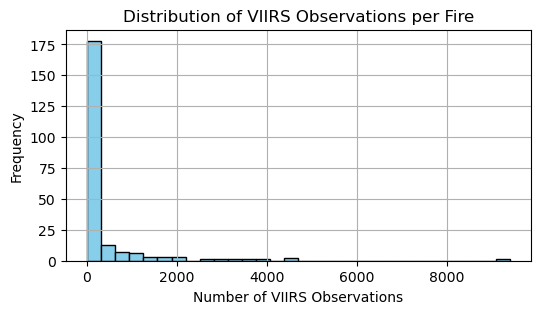

In [24]:
# Get a count of observations per 'fired_id'
viirs_counts = frp_aspen.groupby('fired_id').size().reset_index(name='counts')
print(viirs_counts['counts'].min())
print(viirs_counts['counts'].max())

# Plot the histogram
plt.figure(figsize=(6, 3))
plt.hist(viirs_counts['counts'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of VIIRS Observations per Fire')
plt.xlabel('Number of VIIRS Observations')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Tidy the FRP data: remove null values, check on the obs./fire, and check on date matches

Some observations may not be joined correctly (i.e., spatial overlap but wrong ignition year, etc). We may also have some fires with too few observations. 

In [25]:
# Check on date matches (by year and/or month)
# Filter any observations that dont match the fire year

# First create a year/month column from the VIIRS acquisition date
frp_aspen['ACQ_DATE'] = pd.to_datetime(frp_aspen['ACQ_DATE'])
frp_aspen['ACQ_MONTH'] = frp_aspen['ACQ_DATE'].dt.month.astype(int)
frp_aspen['ACQ_YEAR'] = frp_aspen['ACQ_DATE'].dt.year.astype(int)

frp_aspen['last_date'] = pd.to_datetime(frp_aspen['last_date'])

print(frp_aspen['ACQ_YEAR'].min())
print(frp_aspen['ACQ_YEAR'].max())

# Count the number of VIIRS observations that do not match the ignition year
print(f"Number of VIIRS obs. that do not match the ignition year: {(frp_aspen['ACQ_YEAR'] != frp_aspen['ig_year']).sum()}")

# Filter based on ignition month and year
frp_aspen_f = frp_aspen[
    (frp_aspen['ACQ_YEAR'] >= frp_aspen['ig_year']) & 
    (frp_aspen['ACQ_MONTH'] >= frp_aspen['ig_month']) &
    (frp_aspen['ACQ_YEAR'] <= frp_aspen['last_date'].dt.year) &
    (frp_aspen['ACQ_MONTH'] <= frp_aspen['last_date'].dt.month)
]

# Keep unique rows
frp_aspen_f = frp_aspen_f.drop_duplicates(subset='VID', keep='first')
print(frp_aspen_f.columns)

# Filter out the VIIRS observations with different ignition years
# frp_aspen_f = frp_aspen[frp_aspen['ACQ_YEAR'] == frp_aspen['ig_year']]
print(len(frp_aspen_f))

print(frp_aspen_f['VID'].nunique())

viirs_counts = frp_aspen_f.groupby('fired_id').size().reset_index(name='counts')
print(viirs_counts['counts'].min())
print(viirs_counts['counts'].max())

2018
2023
Number of VIIRS obs. that do not match the ignition year: 5681
Index(['VID', 'LATITUDE', 'LONGITUDE', 'ACQ_DATE', 'ACQ_TIME', 'CONFIDENCE',
       'FRP', 'DAYNIGHT', 'fired_id', 'ig_date', 'ig_day', 'ig_month',
       'ig_year', 'last_date', 'event_dur', 'tot_ar_km2', 'fsr_km2_dy',
       'mx_grw_km2', 'mn_grw_km2', 'mu_grw_km2', 'mx_grw_dte', 'ig_utm_x',
       'ig_utm_y', 'tot_perim', 'pct_aspen', 'geometry', 'ACQ_MONTH',
       'ACQ_YEAR'],
      dtype='object')
65228
65228
1
9299


In [26]:
# Check on fires with < N observations
N = 10

# Get a count of observations per 'fired_id'
print(f'Number of fires with >= {str(N)} observations: {len(viirs_counts[viirs_counts["counts"] >= N])}')
print(f'Percent of events: {round(len(viirs_counts[viirs_counts["counts"] >= N]) / len(viirs_counts) * 100, 3)}')

# Filter out fires with less than 10 observations
ids = viirs_counts[viirs_counts["counts"] >= N]

# Grab the new list of unique FIRED ids
ids = ids['fired_id'].unique().tolist()

# Filter the datasets based on the FIRED ids
frp_aspen_f = frp_aspen_f[frp_aspen_f['fired_id'].isin(ids)]
fired_aspen = fired_aspen[fired_aspen['fired_id'].isin(ids)]

print(len(frp_aspen_f))
print(frp_aspen_f.columns)

viirs_counts_ = frp_aspen_f.groupby('fired_id').size().reset_index(name='counts')
print(f"Min obs: {viirs_counts_['counts'].min()}")
print(f"Max obs: {viirs_counts_['counts'].max()}")
print(frp_aspen_f.head())

Number of fires with >= 10 observations: 102
Percent of events: 80.952
65124
Index(['VID', 'LATITUDE', 'LONGITUDE', 'ACQ_DATE', 'ACQ_TIME', 'CONFIDENCE',
       'FRP', 'DAYNIGHT', 'fired_id', 'ig_date', 'ig_day', 'ig_month',
       'ig_year', 'last_date', 'event_dur', 'tot_ar_km2', 'fsr_km2_dy',
       'mx_grw_km2', 'mn_grw_km2', 'mu_grw_km2', 'mx_grw_dte', 'ig_utm_x',
       'ig_utm_y', 'tot_perim', 'pct_aspen', 'geometry', 'ACQ_MONTH',
       'ACQ_YEAR'],
      dtype='object')
Min obs: 10
Max obs: 9299
           VID   LATITUDE   LONGITUDE   ACQ_DATE ACQ_TIME CONFIDENCE    FRP  \
876446  876446  37.507347 -112.675858 2020-11-18     1954          n  24.28   
876447  876447  37.502945 -112.674408 2020-11-18     1954          n  24.28   
876448  876448  37.504166 -112.669052 2020-11-18     1954          n  24.28   
876763  876763  37.512333 -112.681885 2020-11-19     1936          n   7.04   
876764  876764  37.513638 -112.677109 2020-11-19     1936          n   7.04   

       DAYNIGHT

189859
9299


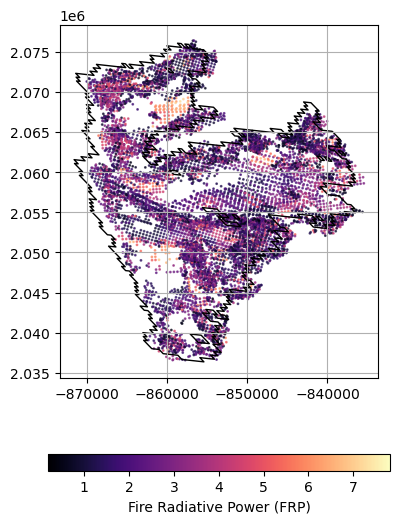

In [27]:
# Make a map of the fire with the most observations

# Sort the VIIRS counts
viirs_counts = viirs_counts.sort_values('counts', ascending=False).reset_index(drop=True)

# Take the first row (the maximum)
max_obs = viirs_counts.iloc[0]['fired_id']
print(max_obs)

# Filter the fire perimeter and VIIRS obs.
perim = fired_aspen[fired_aspen['fired_id'] == max_obs]
obs = frp_aspen_f[frp_aspen_f['fired_id'] == max_obs]
obs = obs.copy()
obs['FRP_log'] = np.log1p(obs['FRP'])
print(len(obs))

# Create the map
fig, ax = plt.subplots(figsize=(4, 5.5))
# Plot VIIRS points
obs.plot(column='FRP_log', ax=ax, legend=True,
         legend_kwds={'label': "Fire Radiative Power (FRP)", 'orientation': "horizontal"},
         cmap='magma', markersize=1, alpha=0.7)
# Plot the fire perimeter
perim.plot(ax=ax, color='none', edgecolor='black', linewidth=1, label='Fire Perimeter')
plt.tight_layout()
plt.grid(True)
plt.show()

65124
65124


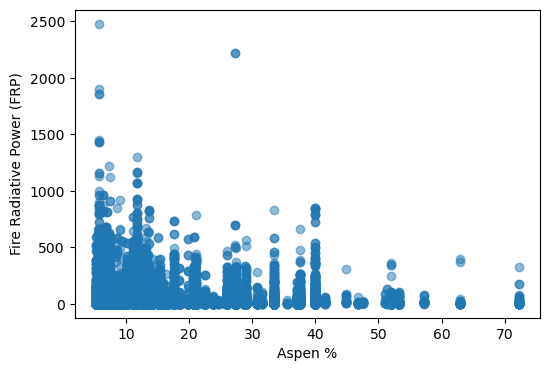

In [28]:
print(len(frp_aspen_f['pct_aspen']))
print(len(frp_aspen_f['FRP']))
      
# Scatterplot of FRP and aspen_pct (fire perimeter)
plt.figure(figsize=(6, 4))  # Set the figure size
plt.scatter(frp_aspen_f['pct_aspen'], frp_aspen_f['FRP'], alpha=0.5)  # Plot with some transparency

# Add titles and labels
plt.ylabel('Fire Radiative Power (FRP)')
plt.xlabel('Aspen %')

plt.show()

## Join VIIRS observations to daily FIRED perimeters

We want to summarize VIIRS observations on a daily basis and then associate them with the correct daily polygon from FIRED. The initial step is to group observations by day.



In [27]:
# Create the daily summary of FRP for each wildfire event

## Create the VIIRS observation buffer (375m2)

The archive VIIRS data is distributed as shapefiles with centroids representing the pixel center of a VIIRS observation. In order to assess characteristics within the VIIRS observations, we want to create a 375m2 buffer around the centroid locations to approximate the VIIRS pixel size.

102
['3518' '4014' '4131' '4225' '5006' '6466' '42237' '42260' '42306' '42308'
 '42426' '42564' '42618' '42699' '42729' '42749' '42751' '42753' '42761'
 '42817' '42867' '42895' '43192' '43301' '43509' '43566' '43577' '43630'
 '43631' '43686' '43692' '43696' '43700' '43702' '43728' '43794' '43824'
 '43845' '43858' '43920' '44668' '44686' '44798' '44848' '44927' '44955'
 '44962' '44969' '44975' '45085' '45158' '45207' '45218' '45219' '45235'
 '45260' '45549' '46365' '46944' '47246' '49956' '59349' '65142' '65643'
 '66217' '67758' '68350' '68490' '68615' '68658' '69172' '69181' '69253'
 '69280' '69482' '69484' '69542' '69552' '69557' '69579' '69601' '69619'
 '69632' '69836' '69841' '69873' '69947' '69962' '69969' '69970' '69988'
 '70006' '70094' '78592' '81338' '81343' '82007' '189371' '189505'
 '189520' '189859' '189869']
315


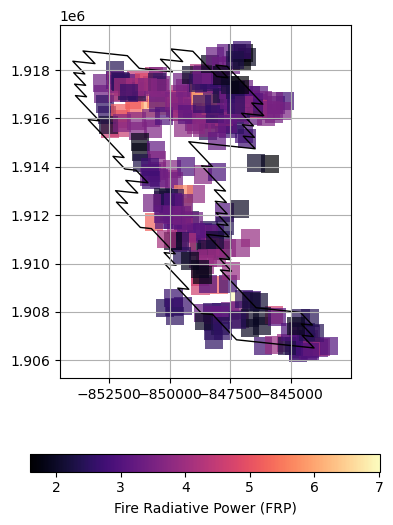

In [33]:
# Create the buffered VIIRS obs.
frp_aspen_plot = frp_aspen_f.copy()
frp_aspen_plot['geometry'] = frp_aspen_plot.geometry.buffer(375, cap_style=3)  # square buffer 375m

print(len(fired_aspen))
print(fired_aspen['fired_id'].unique())

# Let's plot one fire using the FRP column to color the "plots"

# Filter the fire perimeter and VIIRS obs.
perim = fired_aspen[fired_aspen['fired_id'] == "42306"]  # Williams Fork Fire "45811.0"
obs = frp_aspen_plot[frp_aspen_plot['fired_id'] == "42306"]
obs = obs.copy()
obs['FRP_log'] = np.log1p(obs['FRP'])
obs = obs[obs['DAYNIGHT'] == 'D']  # plot only daytime observations
print(len(obs))

# Create the map
fig, ax = plt.subplots(figsize=(4, 5.5))
# Plot VIIRS points
obs.plot(column='FRP_log', ax=ax, legend=True,
         legend_kwds={'label': "Fire Radiative Power (FRP)", 'orientation': "horizontal"},
         cmap='magma', markersize=1, alpha=0.7)
# Plot the fire perimeter
perim.plot(ax=ax, color='none', edgecolor='black', linewidth=1, label='Fire Perimeter')
plt.tight_layout()
plt.grid(True)
plt.show()

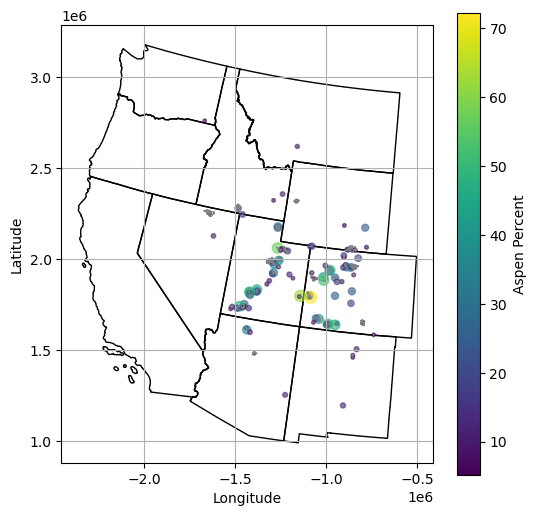

In [34]:
centroid = fired_aspen.copy()
centroid['geometry'] = centroid.geometry.centroid

# Make a spatial map of the centroids now
fig, ax = plt.subplots(figsize=(6, 6))

states.plot(ax=ax, edgecolor='black', linewidth=1, color='none')

# Plot centroids
centroid['size'] = centroid['pct_aspen'] * 10  # Adjust the scaling factor as necessary
centroid.plot(
    ax=ax, markersize=centroid['pct_aspen'], 
    column='pct_aspen', cmap='viridis', 
    legend=True, alpha=0.6, 
    legend_kwds={'label': "Aspen Percent"})

# Optional: Plot the original fire perimeters for context
fired_aspen.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

del centroid

# Save the map as a PNG
plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/Fig1_aspen_fires.png'), dpi=300, bbox_inches='tight')

plt.show()

## Tidy and save out the necessary files

Now that we have a tidy dataframe for both wildfires with >=5% pre-fire aspen cover and their associated nominal or high confidence VIIRS observations, we can save these files out for further processing. 

Some of the processing will occur in GEE, so for these files we want to save a simplified SHP with only the required attribute information (they will be joined back to the full data after processing).

In [35]:
# Check on the observation counts again
viirs_counts = frp_aspen_plot.groupby('fired_id').size().reset_index(name='counts')
print(viirs_counts['counts'].min())
print(viirs_counts['counts'].max())

10
9299


In [36]:
# Filter the daily files
# Get the list of IDs
ids = fired_aspen['fired_id'].unique()

# Load the daily polygons, subset to aspen fires
daily['id'] = daily['id'].astype(str)
daily = daily[daily['id'].isin(ids)]
print(len(daily['id'].unique()))

# Save the daily wildfire perimeters
daily = daily.to_crs(proj)  # ensure the correct projection before exporting
daily.to_file(os.path.join(maindir,'aspen-fire/Aim2/data/spatial/mod/FIRED/fired_daily_west_aspen.gpkg'))

102


In [37]:
# Save the wildfire perimeters
fired_aspen = fired_aspen.to_crs(proj)  # ensure the correct projection before exporting
fired_aspen.to_file(os.path.join(maindir,'aspen-fire/Aim2/data/spatial/mod/FIRED/fired_events_west_aspen.gpkg'))

# Save the VIIRS observations (points)
frp_aspen_f = frp_aspen_f.to_crs(proj)
frp_aspen_f.to_file(os.path.join(maindir,'aspen-fire/Aim2/data/spatial/mod/VIIRS/viirs_obs_fired_events_west_aspen.gpkg'))

# Save the VIIRS observations (plots)
frp_aspen_plot = frp_aspen_plot.to_crs(proj)
frp_aspen_plot.to_file(os.path.join(maindir,'aspen-fire/Aim2/data/spatial/mod/VIIRS/viirs_plots_fired_events_west_aspen.gpkg'))

# Tidy the files for GEE imports

# FIRED perimeters (1km buffer)
print(fired_aspen_1km.columns)
fired_aspen_gee = fired_aspen_1km[['fired_id','ig_date','ig_year','last_date','mx_grw_dte','geometry']]
fired_aspen_gee['ig_date'] = fired_aspen_gee['ig_date'].astype(str)
fired_aspen_gee['last_date'] = fired_aspen_gee['ig_date'].astype(str)
fired_aspen_gee.to_file(os.path.join(maindir,'aspen-fire/Aim2/data/spatial/mod/GEE/fired_events_west_aspen.shp'))

# VIIRS "plots"
print(frp_aspen_plot.columns)
frp_aspen_gee = frp_aspen_plot[['fired_id','VID','ACQ_DATE','DAYNIGHT','geometry']]
frp_aspen_gee['ACQ_DATE'] = frp_aspen_gee['ACQ_DATE'].astype(str)
frp_aspen_gee.to_file(os.path.join(maindir,'aspen-fire/Aim2/data/spatial/mod/GEE/viirs_plots_fired_events_west_aspen.shp'))

print("Success!")

Index(['fired_id', 'ig_date', 'ig_day', 'ig_month', 'ig_year', 'last_date',
       'event_dur', 'tot_pix', 'tot_ar_km2', 'fsr_px_dy', 'fsr_km2_dy',
       'mx_grw_px', 'mn_grw_px', 'mu_grw_px', 'mx_grw_km2', 'mn_grw_km2',
       'mu_grw_km2', 'mx_grw_dte', 'x', 'y', 'ig_utm_x', 'ig_utm_y', 'lc_code',
       'lc_mode', 'lc_name', 'lc_desc', 'lc_type', 'eco_mode', 'eco_name',
       'eco_type', 'tot_perim', 'geometry', 'pct_aspen'],
      dtype='object')
Index(['VID', 'LATITUDE', 'LONGITUDE', 'ACQ_DATE', 'ACQ_TIME', 'CONFIDENCE',
       'FRP', 'DAYNIGHT', 'fired_id', 'ig_date', 'ig_day', 'ig_month',
       'ig_year', 'last_date', 'event_dur', 'tot_ar_km2', 'fsr_km2_dy',
       'mx_grw_km2', 'mn_grw_km2', 'mu_grw_km2', 'mx_grw_dte', 'ig_utm_x',
       'ig_utm_y', 'tot_perim', 'pct_aspen', 'geometry', 'ACQ_MONTH',
       'ACQ_YEAR'],
      dtype='object')


/opt/miniconda3/envs/aspen-fire/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/miniconda3/envs/aspen-fire/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/miniconda3/envs/aspen-fire/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Success!
